# Noise2Void - 2D Example

In [1]:
import sys
sys.executable

'/home/prakash/anaconda3/envs/N2V/bin/python3'

In [2]:
from csbdeep.models import Config, CARE
import numpy as np
from csbdeep.utils import plot_some, plot_history
from csbdeep.utils.n2v_utils import manipulate_val_data

from matplotlib import pyplot as plt

import urllib

import os
import zipfile
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [3]:
# Download data
if not os.path.isdir('./data'):
    os.mkdir('./data')

if not os.path.exists('./data/N2V_exampleData.zip'):
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/KKPX20qD05vp60F/download', './data/N2V_exampleData.zip')
    with zipfile.ZipFile('./data/N2V_exampleData.zip', 'r') as zip_ref:
        zip_ref.extractall('./data/N2V_exampleData')

## Configure

To use Noise2Void with the CARE framework we have to switch the <code>train_scheme</code> from <code>'CARE'</code> to <code>'Noise2Void'</code>. This will turn on the pixel-masking which is needed for Noise2Void training. Furhtermore it is recommended to increase the <code>train_batch_size</code> and enable <code>batch_norm</code>. 

To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels we manipulated <code>n2v_num_pix</code> = 64 pixels simultaniously. 

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

In [4]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = Config('SYXC', n_channel_in=1, n_channel_out=1, unet_kern_size = 3, train_steps_per_epoch=50, train_loss='mse',
                batch_norm = True, train_scheme = 'Noise2Void', train_batch_size = 128, n2v_num_pix = 64,
                n2v_patch_shape = (64, 64), n2v_manipulator = 'uniform_withCP', n2v_neighborhood_radius='5')

vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 50,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'batch_norm': True,
 'train_scheme': 'Noise2Void',
 'n2v_num_pix': 64,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': '5'}

In [5]:
model = CARE(config, 'n2v_2D', basedir='models')

/home/prakash/Desktop/GitClones/n2v/csbdeep/models/care_standard.py:118: UserWarning: output path for model already exists, files may be overwritten: /home/prakash/Desktop/GitClones/n2v/examples/2D/models/n2v_2D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training Data Preparation

For training we load __one__ set of low-SNR images and normalize them to 0-mean and 1-std. This data is used as input data and stored in the variable <code>X</code>. Our target <code>Y</code> is <code>X</code> concatenated with a zero-tensor of the same shape. This zero-tensor is used for the masking of the pixels during training. 

In [6]:
# We need to normalize the data before we feed it into our network, and denormalize it afterwards.
def normalize(img, mean, std):
    zero_mean = img - mean
    return zero_mean/std

def denormalize(x, mean, std):
    return x*std + mean

(240, 256, 256, 1) (240, 256, 256, 2)


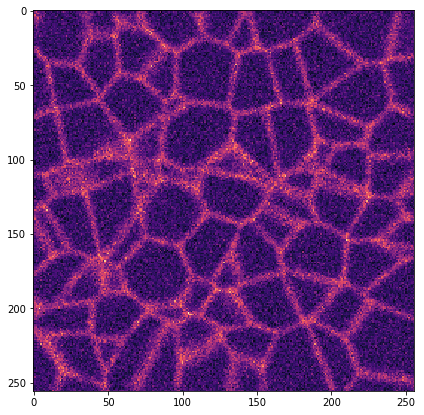

In [7]:
# Load lowSNR data. Note: This can be the same data as we test on. 
# Leave couple slices for validation ;)
X = X = np.load('data/N2V_exampleData/N2V_lowSNR.npy')[:240,...]

mean, std = np.mean(X), np.std(X)
X = normalize(X, mean, std)

# We concatenate an extra channel filled with zeros. It will be internally used for the masking.
Y = np.concatenate((X, np.zeros(X.shape)), axis=3)

# All training images are noisy:
plt.figure(figsize=(7,7))
plt.imshow(Y[0,...,0], cmap="magma")
print(X.shape, Y.shape)

### Validation Data Preparation

There are two possiblities to build the validation set:

1. Training-Data like: Meaning that the validations loss is only computed on a fixed number of manipulated (masked) pixels. This means that we randomly select a fixed number of pixels before training and manipulate them like it is done for the training data during training. 
2. Test-Data like: Meaning that the validation loss is computed on all pixels of the validation set.
The pixels are __not__ manipulated.
This setup is more like the setup during testing.

In our paper we chose *option 1* to have the same loss during validation as during training. But using *option 2* will result in a more stable validation loss since it is computed over __all__ instead of a subset of pixels.

/home/prakash/Desktop/GitClones/n2v/csbdeep/utils/n2v_utils.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return patch[slices]


(16, 256, 256, 1) (16, 256, 256, 2)


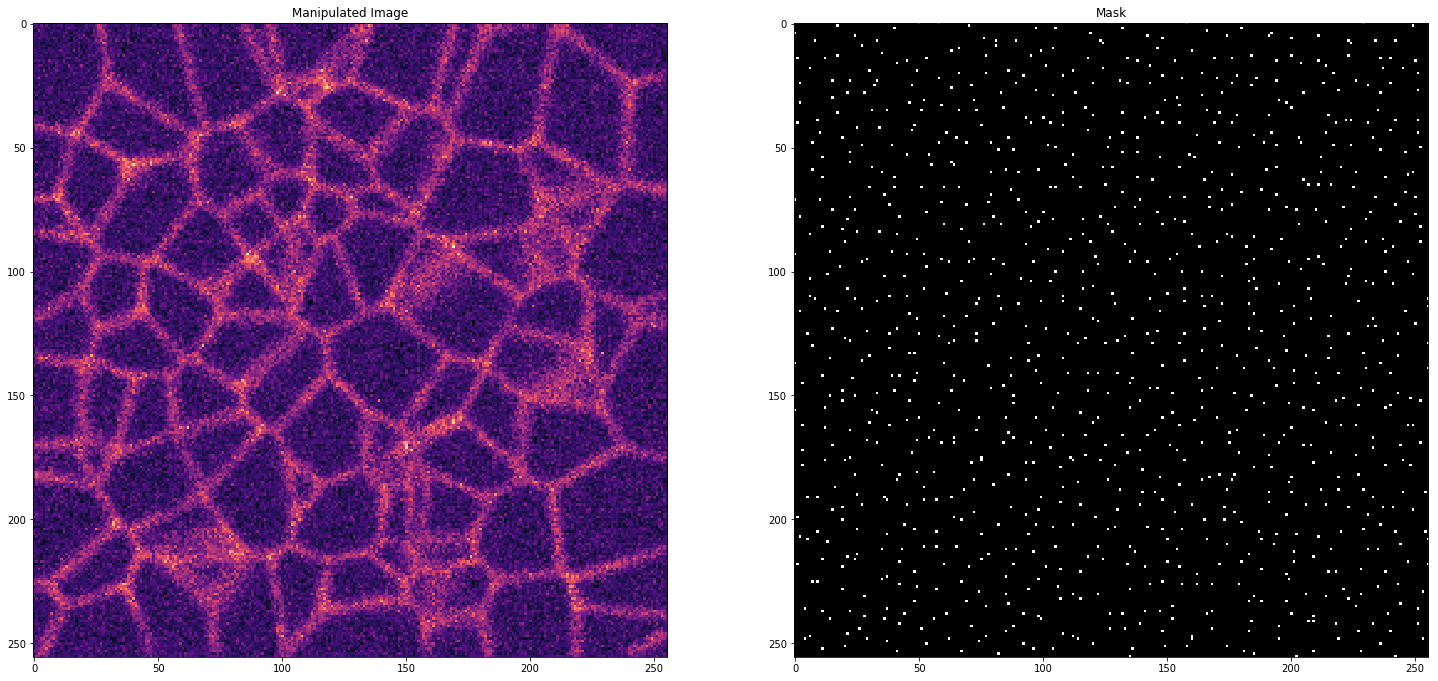

In [8]:
# Load the remaining data as validation data
X_val = np.load('data/N2V_exampleData/N2V_lowSNR.npy')[240:,...]
X_val = normalize(X_val, mean, std)

# 1. Option
Y_val = np.concatenate((X_val.copy(), np.zeros(X_val.shape)), axis=3) 
manipulate_val_data(X_val, Y_val,num_pix=256*256/64 , shape=(256, 256))

# 2. Option
#Y_val = np.concatenate((X_val.copy(), np.ones(X_val.shape)), axis=3)

# The validation set is noisy as well:

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(X_val[0,...,0], cmap="magma")
plt.title("Manipulated Image")
plt.subplot(1,2,2)
plt.imshow(Y_val[0,...,1], cmap="gray")
plt.title("Mask")
print(X_val.shape, Y_val.shape)

## Training

In [9]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
50/50 [==============================] - 34s 687ms/step - loss: 0.7115 - mse: 1.0060 - mae: 0.7887 - val_loss: 0.6458 - val_mse: 0.5208 - val_mae: 0.6248
Epoch 2/100
50/50 [==============================] - 29s 588ms/step - loss: 0.4715 - mse: 0.7012 - mae: 0.7053 - val_loss: 0.4669 - val_mse: 0.6221 - val_mae: 0.6694
Epoch 3/100
50/50 [==============================] - 30s 609ms/step - loss: 0.4510 - mse: 0.6729 - mae: 0.6954 - val_loss: 0.4482 - val_mse: 0.6890 - val_mae: 0.7007
Epoch 4/100
50/50 [==============================] - 30s 604ms/step - loss: 0.4392 - mse: 0.6669 - mae: 0.6940 - val_loss: 0.4497 - val_mse: 0.7509 - val_mae: 0.7187
Epoch 5/100
50/50 [==============================] - 31s 629ms/step - loss: 0.4298 - mse: 0.6573 - mae: 0.6896 - val_loss: 0.4346 - val_mse: 0.6770 - val_mae: 0.6822
Epoch 6/100
50/50 [==============================] - 30s 603ms/step - loss: 0.4290 - mse: 0.6505 - mae: 0.6871 - val_loss: 0.4281 - val_mse: 0.6566 - val_mae: 0.6891
Epoc

50/50 [==============================] - 31s 624ms/step - loss: 0.4060 - mse: 0.6463 - mae: 0.6877 - val_loss: 0.3962 - val_mse: 0.6507 - val_mae: 0.6897
Epoch 51/100
50/50 [==============================] - 31s 615ms/step - loss: 0.4057 - mse: 0.6381 - mae: 0.6835 - val_loss: 0.3950 - val_mse: 0.5835 - val_mae: 0.6564

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 52/100
50/50 [==============================] - 30s 596ms/step - loss: 0.4075 - mse: 0.6408 - mae: 0.6851 - val_loss: 0.3949 - val_mse: 0.6364 - val_mae: 0.6856
Epoch 53/100
50/50 [==============================] - 31s 620ms/step - loss: 0.4052 - mse: 0.6422 - mae: 0.6854 - val_loss: 0.3947 - val_mse: 0.6348 - val_mae: 0.6893
Epoch 54/100
50/50 [==============================] - 31s 613ms/step - loss: 0.4051 - mse: 0.6395 - mae: 0.6832 - val_loss: 0.3941 - val_mse: 0.5795 - val_mae: 0.6553
Epoch 55/100
50/50 [==============================] - 32s 646ms/step - loss: 0.4067 - mse: 0.639

Epoch 98/100
50/50 [==============================] - 31s 613ms/step - loss: 0.4046 - mse: 0.6407 - mae: 0.6845 - val_loss: 0.3924 - val_mse: 0.6209 - val_mae: 0.6796
Epoch 99/100
50/50 [==============================] - 30s 609ms/step - loss: 0.4044 - mse: 0.6451 - mae: 0.6866 - val_loss: 0.3924 - val_mse: 0.6276 - val_mae: 0.6790
Epoch 100/100
50/50 [==============================] - 30s 593ms/step - loss: 0.4036 - mse: 0.6435 - mae: 0.6865 - val_loss: 0.3927 - val_mse: 0.6426 - val_mae: 0.6917

Loading network weights from 'weights_best.h5'.


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


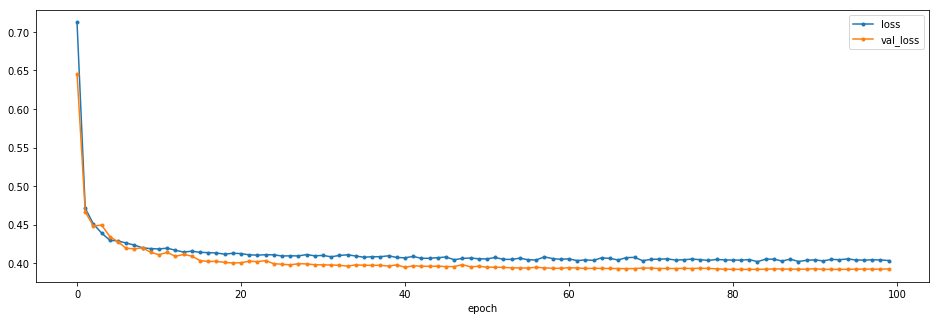

In [10]:
# Lets look at the training and validation loss.

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Evaluation

For the evaluation we load the test low-SNR and ground truth data. Since we have simulated low- and high-SNR images via exposure, we have to normalize the values to compute a meaningful PSNR value. The ground truth data has a simulated exposure of 10'000 and the low-SNR data has an exposure of 20. 

In [ ]:
# model.load_weights( name='weights_now.h5')

In [11]:
test_gt = np.load('data/N2V_exampleData/N2V_gt.npy')
# Normalize exposure
test_gt = test_gt/10000 * 20

In [12]:
test_lowSNR = np.load('data/N2V_exampleData/N2V_lowSNR.npy')
# normalize data with mean and std of the training data
test_lowSNR = normalize(test_lowSNR, mean, std)

In [13]:
predictions = []
# Denoise all images
for i in range(test_lowSNR.shape[0]):
    predictions.append(denormalize(model.predict(test_lowSNR[i], axes='YXC',normalizer=None ), mean, std))
predictions = np.array(predictions)

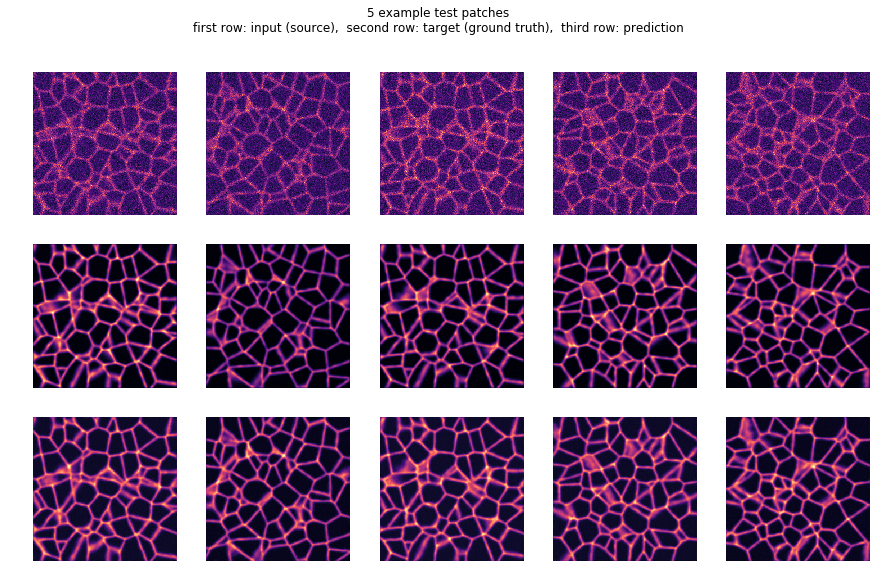

In [14]:
plt.figure(figsize=(15,9))
plot_some(test_lowSNR[:5], test_gt[:5], predictions[:5])
plt.suptitle('5 example test patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: prediction');

In [15]:
def PSNR(gt, pred, range_):
    mse = np.mean((gt - pred)**2)
    return 20 * np.log10((range_)/np.sqrt(mse))

In [16]:
def stack_PSNR(gt, pred):
    psnr = 0
    min_gt, max_gt = np.min(gt), np.max(gt)
    for i in range(gt.shape[0]):
        psnr += PSNR(gt[i], pred[i], max_gt-min_gt)
    
    return psnr/gt.shape[0]

In [17]:
print('PSNR')
print('Input:', stack_PSNR(test_gt, test_lowSNR))
print('Prediction:', stack_PSNR(test_gt, predictions))

PSNR
Input: 8.761603419810816
Prediction: 31.446853113657056
